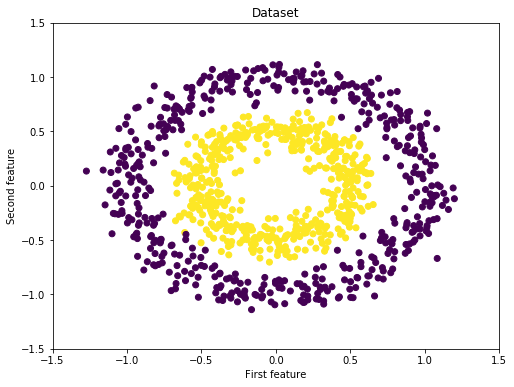

Shape X_train: (750, 2)
Shape y_train: (750, 1)
Shape X_test: (250, 2)
Shape y_test: (250, 1)


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
np.random.seed(123)
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.clf()
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall") 
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    plt.show()

def evaluate_binary_clf_proba(y_actual, y_prob):
    plt.clf()
    precisions, recalls, thresholds = precision_recall_curve(y_actual, y_prob)
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    fpr, tpr, _ = roc_curve(y_actual, y_prob)
    plt.plot(fpr, tpr, marker='.')
    auc = roc_auc_score(y_actual, y_prob)
    print('auc: ', auc)
    plt.show()

def evaluate_binary_clf_bin(y_actual, y_bin):
    plt.clf()
    print(confusion_matrix(y_actual, y_bin))
    print('precision: ', precision_score(y_actual, y_bin))
    print('recall: ', recall_score(y_actual, y_bin))
    print('f1-score: ', f1_score(y_actual, y_bin))

X, y_true = make_circles(n_samples=1000, factor=0.5, noise=.1)

fig = plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=y)
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.title("Dataset")
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.show()
# Reshape targets to get column vector with shape (n_samples, 1)
y_true = y_true[:, np.newaxis]
# Split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_true)

print(f'Shape X_train: {X_train.shape}')
print(f'Shape y_train: {y_train.shape}')
print(f'Shape X_test: {X_test.shape}')
print(f'Shape y_test: {y_test.shape}')

X_train_s = X_train[:4]
y_train_s = y_train[:4]

In [30]:
class NeuralNetwork:
    
    def __init__(self):
        pass

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def append_bias(self, X):
        n_samples, n_features = X.shape
        ones = np.ones(shape=(n_samples, 1))
        X1 = np.concatenate((X, ones),axis = 1)
        return X1
    
    def predict(self, X):
        """
        Computes and returns network predictions for given dataset
        """
        h_o, y_o = self.forward_pass(X)
        y_bin = [1 if elem >= 0.5 else 0 for elem in y_o]

        return np.array(y_bin)[:, np.newaxis]
    
    def predict_proba(self, X):
        h_o, y_o = self.forward_pass(X)
        return y_o
    
    def forward_pass(self, X1):
        
        """
        Propagates the given input X forward through the net.
        """
        # Compute activations and outputs of hidden units
        
        h_i = np.dot(X1, self.w1)
#         h_o = self.append_bias(self.sigmoid(h_i))
        h_o = self.sigmoid(h_i)

        y_i = np.dot(h_o, self.w2)
        y_o = self.sigmoid(y_i)
        
        return h_o, y_o
    
    def train_gradient_descent(self, X, y, learning_rate=0.01, n_iters=100):
        """
        Trains a linear regression model using gradient descent
        """
        # Step 0: Initialize the parameters
        # 3 layers: w1, w2
        n_samples, n_features = X.shape
#         X1 = self.append_bias(X)   
        X1 = X

        nodes_num_layer1 = 2
#         self.w1 = np.random.rand(n_features + 1, nodes_num_layer1)
        self.w1 = np.random.rand(n_features, nodes_num_layer1)

        
        # layer 2 parameter number can be configed 
#         self.w2 = np.random.rand(nodes_num_layer1 + 1, 1)
        self.w2 = np.random.rand(nodes_num_layer1, 1)

        
        costs = []
        # Step 1: Loop until iterate enoughf
        

        for k in range(n_iters):
            # forward predict impls
            h_o, y_o = self.forward_pass(X1)
            
            # e3 = y - yr
            # e2 = w2*e3*h2*(1-h2)
            # dJ/dw2 = h2*e3
            # dJ/dw1 = h1*e2 = h1*w2*e3*h2*(1-h2)
            
            e3 = y_o - y
            e2 = np.dot(np.dot(e3, self.w2.T), np.dot(h_o.T, 1 - h_o))
            # Step 2: Compute cost over training set
            cost = -(1 / n_samples) * np.sum(y * np.log(y_o) + (1 - y) * np.log(1 - y_o))
            costs.append(cost)
            if k % (n_iters / 10) == 0:
                print(f"Cost at iteration {k}: {cost}")
            # Step 3: Compute the gradients
            dJ_dw2 = 1.0 / n_samples * np.dot(h_o.T, e3)
#             print(X1.shape)
#             print(e2.shape)
#             print(w1.shape)
            dJ_dw1 = 1.0 / n_samples * np.dot(X1.T, e2)
#             print(dJ_dw2)
#             print(dJ_dw1)
#             print(self.w1)
#             gradient = get_gradient()
            # Step 4: Update the parameters
            self.w2 = self.w2 - learning_rate * dJ_dw2
            self.w1 = self.w1 - learning_rate * dJ_dw1
        return self.w1, self.w2, costs
n_iters = 1000
learning_rate = 0.01
nn = NeuralNetwork()
w1, w2, costs = nn.train_gradient_descent(X_train, y_train, learning_rate, n_iters)

Cost at iteration 0: 0.6949602598089456
Cost at iteration 100: 0.6944860560214583
Cost at iteration 200: 0.6941385761024921
Cost at iteration 300: 0.6938786607230367
Cost at iteration 400: 0.6936819989799164
Cost at iteration 500: 0.6935322423389161
Cost at iteration 600: 0.6934177967098264
Cost at iteration 700: 0.6933301625817662
Cost at iteration 800: 0.693262981998495
Cost at iteration 900: 0.6932114410660842


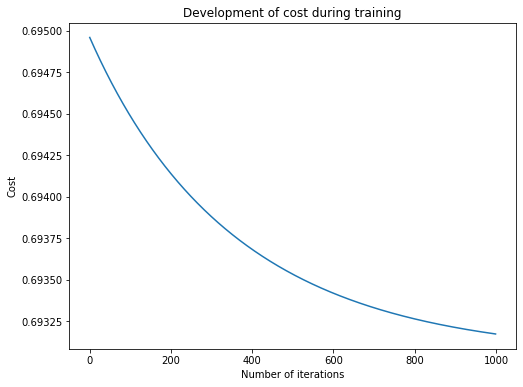

[[ 80 299]
 [  0 371]]
precision:  0.5537313432835821
recall:  1.0
f1-score:  0.7127761767531221
[[ 20 101]
 [  0 129]]
precision:  0.5608695652173913
recall:  1.0
f1-score:  0.7186629526462395


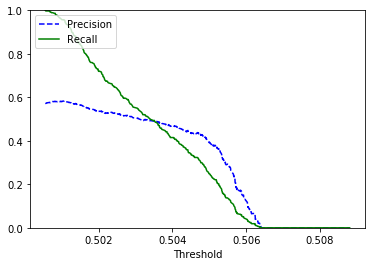

auc:  0.5059917928439858


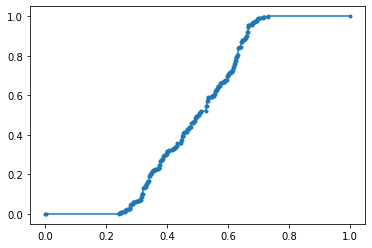

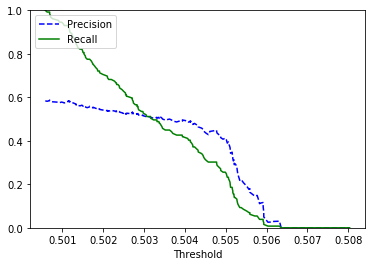

auc:  0.47850599013389716


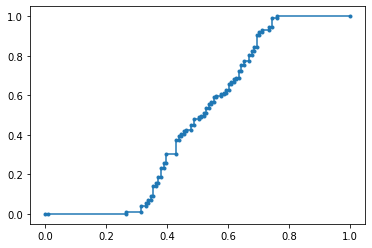

In [31]:
fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(n_iters), costs)
plt.title("Development of cost during training")
plt.xlabel("Number of iterations")
plt.ylabel("Cost")
plt.show()

n_samples, _ = X_train.shape
n_samples_test, _ = X_test.shape

y_p_train = nn.predict(X_train)
y_p_test = nn.predict(X_test)

evaluate_binary_clf_bin(y_train, y_p_train)
evaluate_binary_clf_bin(y_test, y_p_test)

y_proba_train = nn.predict_proba(X_train)
y_proba_test = nn.predict_proba(X_test)

evaluate_binary_clf_proba(y_train, y_proba_train)
evaluate_binary_clf_proba(y_test, y_proba_test)
